In [1]:
import os
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from scipy.spatial import distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import   Dense

from hse_dialog_tree.kmeans_names import get_names
from hse_dialog_tree.utils.cpu import get_processor_info
from hse_dialog_tree.utils.files import load_pickle

LANG = 'rus'
print(get_processor_info())

 Intel Xeon Processor (Cascadelake) x 4


In [2]:
dramas = load_pickle(f'data/{LANG}/content_all.pkl.zip')

dramas_texts = []
for k, v in dramas.items():
    dramas_texts.append(v)

In [3]:
vectors = load_pickle(f'data/{LANG}/02_vectors_v2.pkl.zip')
sentence_to_vector = load_pickle(f'data/{LANG}/02_sentence_to_vector_v2.pkl.zip')

cluster_model_kmeans = load_pickle('steps/03_kmeans/kmeans_v2_044.pkl.zip')
cluster_names = get_names(cluster_model_kmeans)
assert cluster_names is not None

In [4]:
def ngrams_from_vector(vec, n=3):
    return [vec[i: i+n] for i in range(len(vec)-n + 1)]

In [5]:
cluster_vecs = []
cluster_vecs_text_no = []
for i, drama in enumerate(tqdm(dramas_texts)):
    for part in drama:
        clusters = []
        for person, sent in part:
            if sent not in sentence_to_vector:
                continue # Skip empty or too long texts
            sent_vec = sentence_to_vector[sent]
            clusters.append(sent_vec)
        cluster_vecs.append(clusters)
        cluster_vecs_text_no.append(i)

100%|██████████| 210/210 [00:26<00:00,  7.82it/s]


In [6]:
all_ngrams = []

for clusters_vec in tqdm(cluster_vecs):
    all_ngrams.extend(ngrams_from_vector(clusters_vec, n=3))

100%|██████████| 5869/5869 [00:00<00:00, 13480.33it/s]


In [7]:
len(all_ngrams)

198708

In [8]:
clusters_num = 44

# Моя реализация сети

In [9]:
cluster_vecs_text_no_train, _ = train_test_split(list(set(cluster_vecs_text_no)), test_size=0.2, random_state=42)

In [10]:
len(cluster_vecs), len(cluster_vecs_text_no)

(5869, 5869)

In [11]:
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = [], [], [],[]
X_lstm_all, y_lstm_all = [], []
X_ngrams_all = []
for vec, text_no in zip(tqdm(cluster_vecs), cluster_vecs_text_no):
    if len(vec) < 3:
        continue
    for ngrams in ngrams_from_vector(vec, n=4):
        X_lstm = ngrams[:-1]
        cl = cluster_model_kmeans.predict(np.array([ngrams[-1]]))[0]
        y_lstm = cluster_model_kmeans.cluster_centers_[cl]
#         y_lstm = ngrams[-1]
        
        X_ngrams_all.append(cluster_model_kmeans.predict(np.array(ngrams[:-1])))
        X_lstm_all.append(X_lstm)
        y_lstm_all.append(y_lstm)
        if text_no in cluster_vecs_text_no_train:
            X_lstm_train.append(X_lstm)
            y_lstm_train.append(y_lstm)
        else:
            X_lstm_test.append(X_lstm)
            y_lstm_test.append(y_lstm)

X_lstm_train = np.array(X_lstm_train)
X_lstm_test = np.array(X_lstm_test)
y_lstm_train = np.array(y_lstm_train)
y_lstm_test = np.array(y_lstm_test)
X_lstm_all = np.array(X_lstm_all)
y_lstm_all = np.array(y_lstm_all)
X_ngrams_all = np.array(X_ngrams_all)
print(len(X_lstm_train))     

100%|██████████| 5869/5869 [02:57<00:00, 33.10it/s] 


145084


In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

In [72]:
clusters_num = 44
hidden_size = 10

model = Sequential()
model.add(layers.LSTM(128, input_shape=(None, 512)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(512))

# model.add(layers.Dense(clusters_num, activation='softmax'))
model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['CosineSimilarity', 'MSE'])

model.summary()

model.fit(X_lstm_train, y_lstm_train, validation_data=(X_lstm_test, y_lstm_test),
          epochs=4, verbose=1,
         )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               328192    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
Total params: 394,752
Trainable params: 394,496
Non-trainable params: 256
_________________________________________________________________
Epoch 1/4
4534/4534 [==============================] - 39s 8ms/step - loss: 0.0013 - cosine_similarity: 0.5148 - MSE: 0.0013 - val_loss: 2.7610e-04 - val_cosine_similarity: 0.6230 - val_MSE: 2.7610e-04
Epoch 2/4
4534/4534 [=====================

In [73]:
predict_lstm_train = model.predict(X_lstm_train)
predict_lstm_test = model.predict(X_lstm_test)

In [74]:
predict_lstm_train_cluster =cluster_model_kmeans.predict(predict_lstm_train)
y_lstm_train_cluster =cluster_model_kmeans.predict(y_lstm_train)
predict_lstm_test_cluster =cluster_model_kmeans.predict(predict_lstm_test)
y_lstm_test_cluster =cluster_model_kmeans.predict(y_lstm_test)

In [75]:
(predict_lstm_train_cluster == y_lstm_train_cluster).mean()

0.06877395164180751

In [76]:
(predict_lstm_test_cluster == y_lstm_test_cluster).mean()

0.05435252020482448

In [77]:
cluster_seq_emb = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
ngrams_vecs = cluster_seq_emb.predict(X_lstm_all)

# Kmeans 2

In [78]:
ngram_kmeans = MiniBatchKMeans(n_clusters=25, random_state=42)
ngram_clusters = ngram_kmeans.fit_predict(ngrams_vecs)

100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


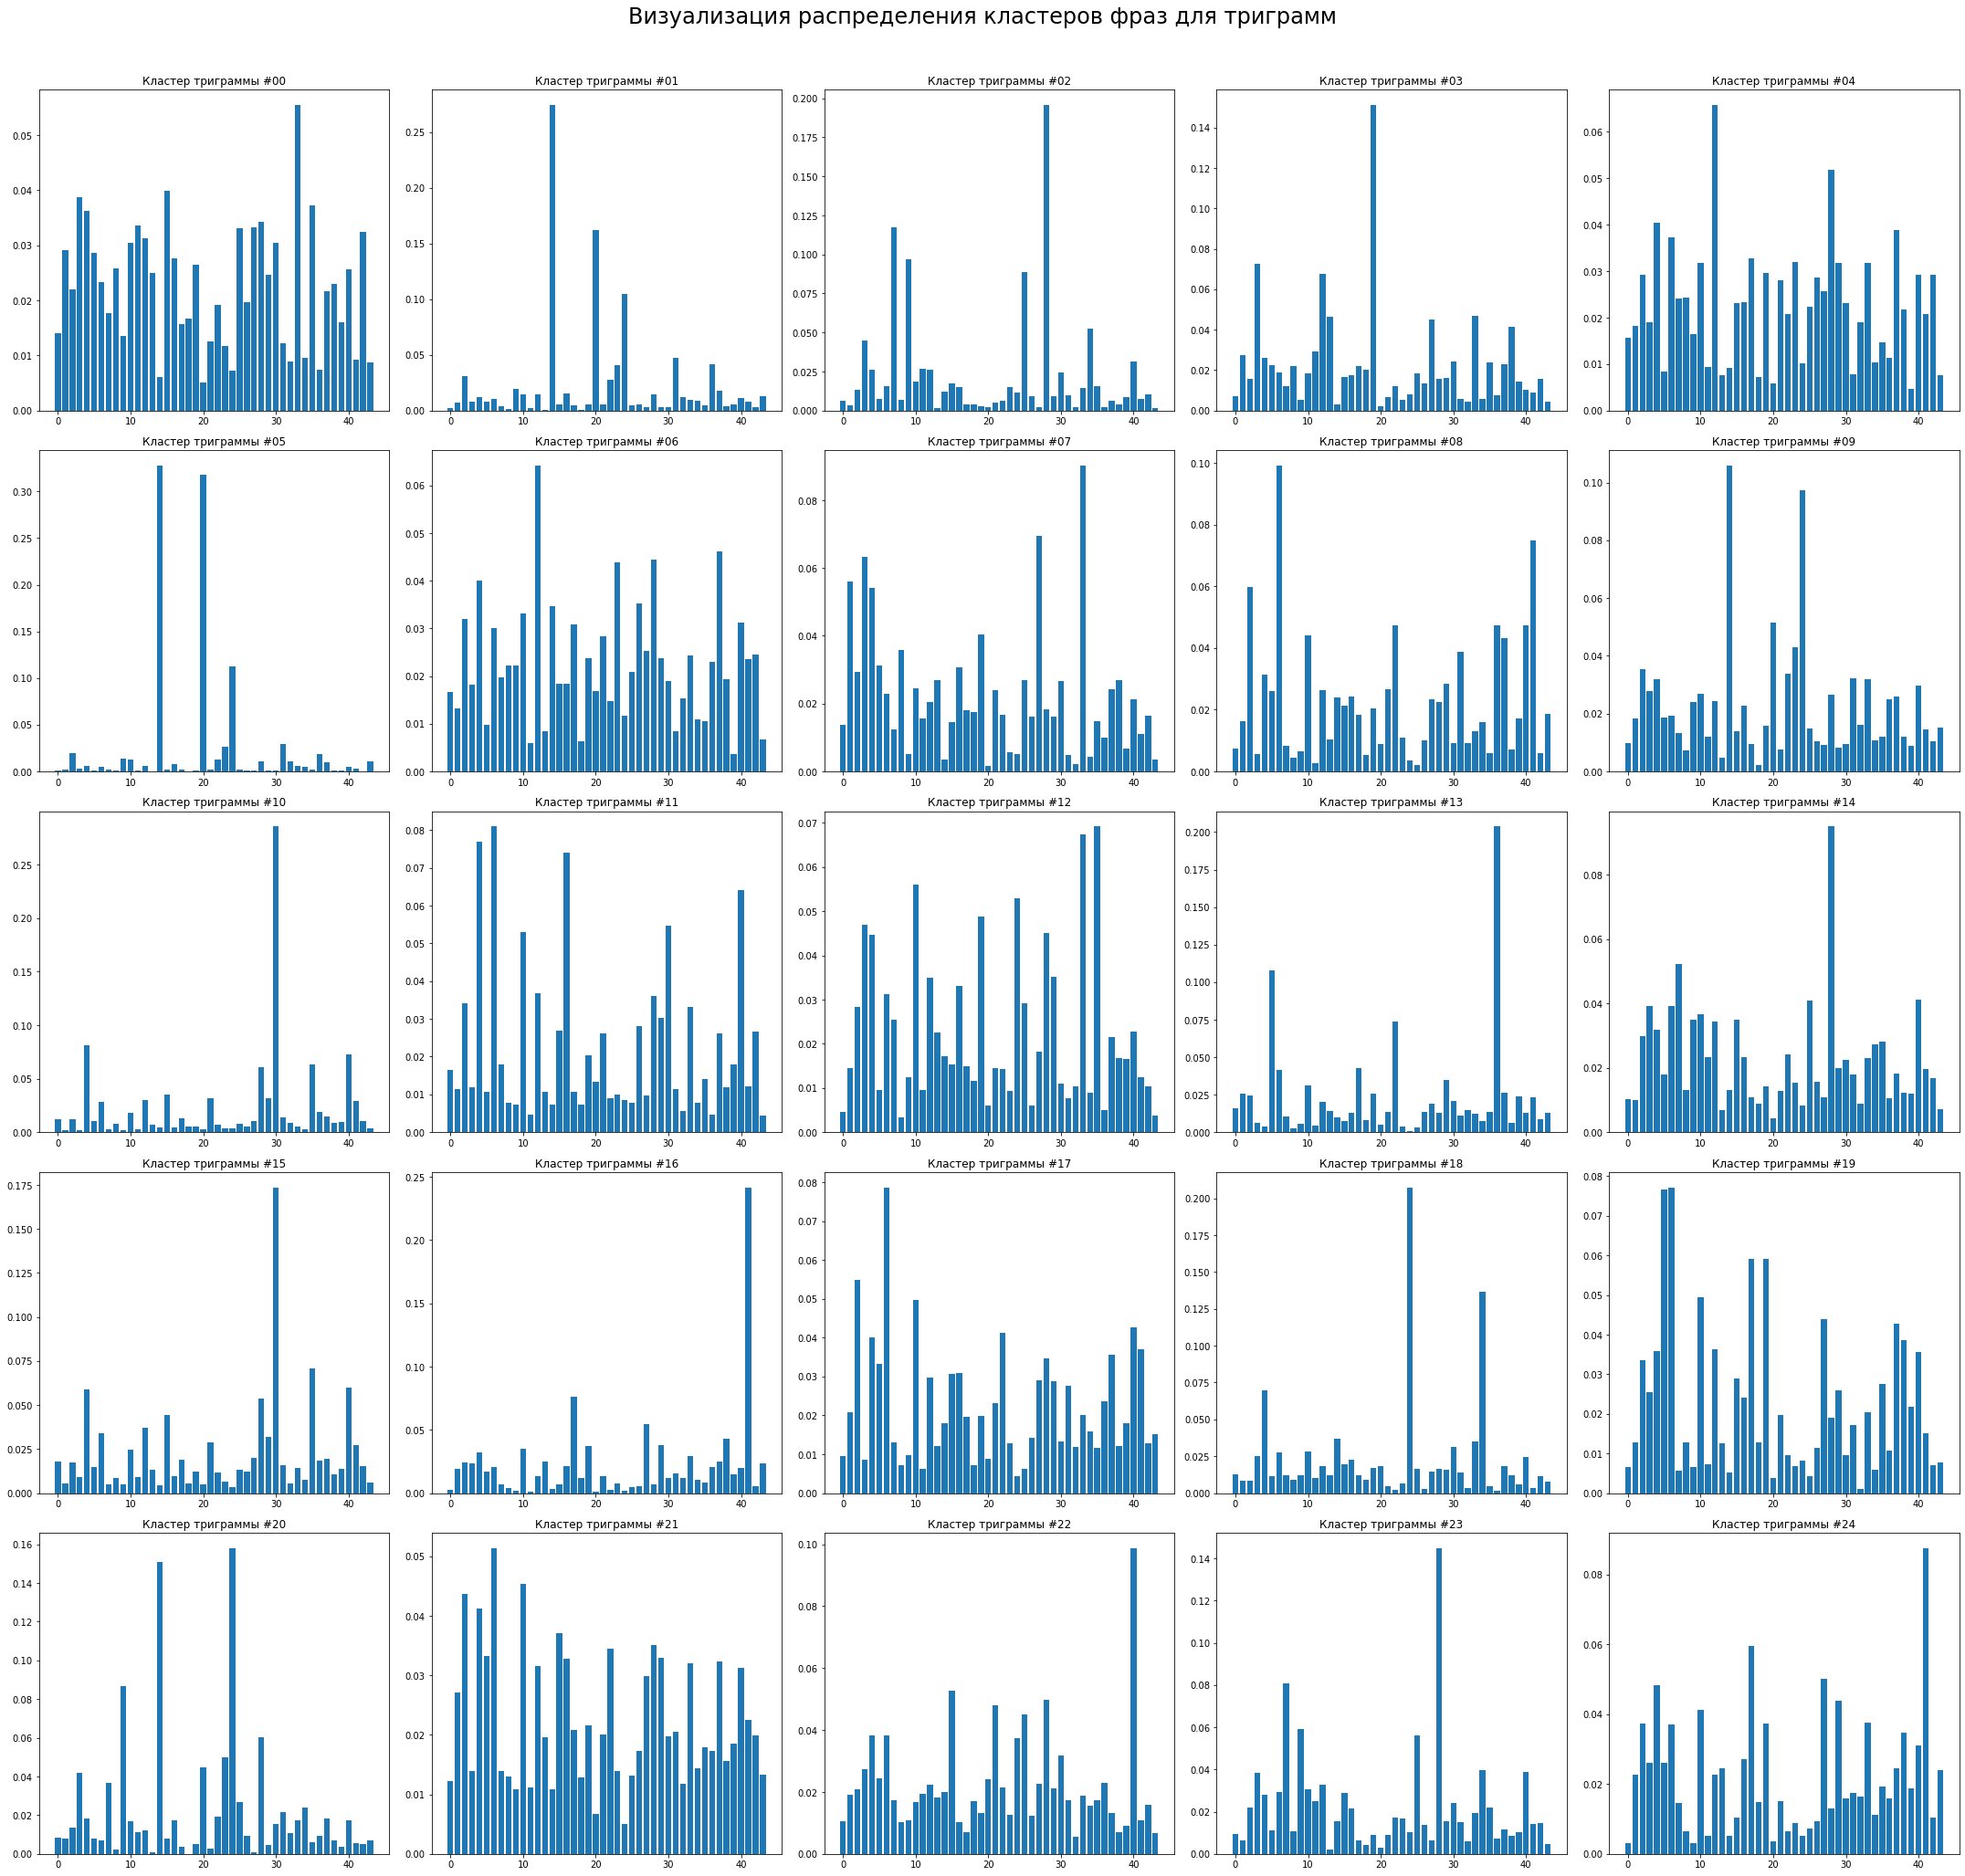

In [79]:
plt.figure(figsize=(30, 30), facecolor='w')
plt.suptitle('Визуализация распределения кластеров фраз для триграмм', fontsize=24)
for cluster_num in tqdm(range(25)):
    plt.subplot(5, 5, cluster_num + 1)
    counter = [0 for i in range(44)]
    for row in X_ngrams_all[ngram_clusters == cluster_num]:
        for it in row:
            counter[it] += 1
    counter = np.array(counter)
    counter = counter / counter.sum()
    
    plt.bar(range(len(counter)) , counter)
    plt.title('Кластер триграммы #{:02d}'.format(cluster_num))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [80]:
_name = 'junk/03_train_recurrent_02/'
os.mkdir(_name)
model.save(_name + 'tf.hdf5')
dump_pickle(ngram_kmeans, _name + 'kmeans.pkl.zip')

# Graph

Перебираем все кластера

Берем те ngramms, последовательность которых относится к данному кластеру

Строим граф - будет словарем, в ключе кортеж двух кластеров, в значении следующий

In [81]:
c = Counter()
c.update(ngram_clusters)
c.most_common()

[(0, 44042),
 (21, 27641),
 (14, 18525),
 (17, 18077),
 (8, 9845),
 (9, 8792),
 (23, 8658),
 (3, 8368),
 (13, 5703),
 (15, 5616),
 (24, 5447),
 (1, 4838),
 (7, 4229),
 (22, 2800),
 (2, 2607),
 (4, 2482),
 (16, 2097),
 (11, 2036),
 (20, 1974),
 (5, 1970),
 (12, 1942),
 (18, 1774),
 (10, 1504),
 (19, 1439),
 (6, 1305)]

In [82]:
# кластер-диалог, кортеж-ключ, кластер-фразы
graph = {}
for cluster_num in range(ngram_kmeans.n_clusters):
    graph_ngrams = X_ngrams_all[ngram_clusters == cluster_num]
    graph[cluster_num] = defaultdict(set)
    for row in graph_ngrams:
        key = tuple(row[:-1])
        val = row[-1]
        graph[cluster_num][key].add(val)

In [83]:
# кластер-диалог, кластер-фразы до, кластер-фразы после
graph_simple = {}
for k, v in graph.items():
    graph_simple[k] = defaultdict(set)
    for k2, v2 in graph[k].items():
        for key1, key2 in zip(k2, k2[1:]):
            graph_simple[k][key1].add(key2)
        for x in v2:
            graph_simple[k][k2[-1]].add(x)

In [84]:
# кластер-диалог, название кластера фразы до, название кластера фразы после
graph_named = {}
for k, v in graph_simple.items():
    graph_named[k] = {}
    for k2, v2 in graph_simple[k].items():
        key = cluster_names[k2]
        val = [cluster_names[x] for x in v2]
        graph_named[k][key] = val

In [85]:
g = Digraph('G', filename='graph_nums.gv')
for k, v in graph_simple[0].items():
    for text in v:
        g.edge(str(k), str(text))
# g.view()
g.render()  

'graph_nums.gv.pdf'

In [86]:
g = Digraph('G', filename='graph_text.gv')
for k, v in graph_named[0].items():
    for text in v:
        g.edge(str(k), str(text))
g.render() 

'graph_text.gv.pdf'

In [87]:
# KV storage: ngram cluster -> list of text
cluster_to_text = defaultdict(list)
for i, drama in enumerate(tqdm(dramas_texts)):
    for part in drama:
        clusters = []
        for person, sent in part:
            if sent not in sentence_to_vector:
                continue # Skip empty or too long texts
            sent_vec = sentence_to_vector[sent]
            cluster =  cluster_model_kmeans.predict(sent_vec.reshape(1, -1))[0]
            cluster_to_text[cluster].append(sent)

100%|██████████| 210/210 [01:26<00:00,  2.43it/s]


In [89]:
import random
import typing

def print_random_path(graph:typing.Dict[int, typing.Iterable], count=3, node=None, seed=None):
    r = random.Random(seed)
    if node is None:
        node = r.choice(list(graph.keys()))
    for i in range(count):
        node_name = cluster_names[node]
        node_text = r.choice(cluster_to_text[node])
        print('{:>4} {:<30}\t{}\n'.format(node, node_name, node_text))
        node = r.choice(list(graph[node]))

In [90]:
print_random_path(graph_simple[6], count=5, seed=42)

  18 "Хорошо", "молодец"           	Ну и прекрасно!

   2 Ответ                         	Я и не спорю: он хороший человек; но это не мой идеал. Мне с ним скучно.

  19 Короткий вопрос               	А бурмистра что же? Тоже?

  15 Небольшое повествование       	Это странно... Впрочем, я готов вам верить. Может быть, вы действительно не знаете
            причины... Хотите, я вам скажу, зачем я уезжаю?

   8 Место, направление            	Куда же вы, господа? Вы не от меня ли бежите?



In [91]:
print_random_path(graph_simple[6], count=5, seed=40)

  40 Длинное рассуждение           	Эх, старый! Девке воля Милей всего. Ни терем твой точеный, Ни соболи, бобры, ни рукавички Строченые не дороги; на мысли У девушки Снегурочки другое: С людьми пожить; подружки нужны ей Веселые да игры до полночи, Весенние гулянки да горелки С ребятами, покуда...

  23 Смерть                        	— А по-моему так лучше убить, чем проклясть. —

  11 Просьба уйти                  	Не оставляйте нас.

  29 Отрицание                     	Да, право, нет. Неловко, совсем неловко.

   7 Негативное восклицание        	Да. (Кричит.) Гришка!



In [92]:
matrix = np.zeros(shape=(cluster_model_kmeans.n_clusters, cluster_model_kmeans.n_clusters))
for cluster_num in range(ngram_kmeans.n_clusters):
    for k, v in graph_simple[cluster_num].items():
        for vv in v:
            matrix[k, vv] = 1
matrix.mean()

1.0

# Нейросетевой граф

In [93]:
def print_random_dialog(start_text, count=10):
    _texts = [start_text, ]
    _vectors = [sentence_to_vector[start_text], ]

    for i in range(count):
        seq = np.array([_vectors])
        new_vec = model.predict(seq)[0]

        min_dist = 10**100
        min_sent = None
        min_vec = None
        for sent, vec in sentence_to_vector.items():
            d = distance.euclidean(new_vec, vec)
            skip = False
            for v in _vectors:
                if (vec == v).mean() == 1:
                    skip = True
                    break
            if skip:
                continue
            if d < min_dist:
                min_dist = d
                min_sent = sent
                min_vec = vec
        _texts.append(min_sent)
        _vectors.append(min_vec)
    #     _vectors.append(new_vec)

    print(*_texts, sep='\n==============\n')

In [95]:
for i in range(10):
    node = random.choice(list(graph_simple[0].keys()))
    text = random.choice(cluster_to_text[node])
    print_random_dialog(text)
    print('\n=========================================\n')

Какую казнь еще готовишь в сем совете? К чему иному жизнь моя тебе нужна? Спрягайся с Дарием, неверная княжна! Будь счастлива! Прости...
Я-с. Только, Авдотья Максимовна, как собственно теперича этот барин за все свои
                невежества не стоит того, чтобы вы его любили, так уж я буду в надежде-с.
Прогнея... ах, постой... жестокая Прогнея! Ты с Филомелой жизнь отъемлешь у Терея, Вселяя в сердце мне собор лютейших мук; Но нет, я из твоих ее исторгну рук. Пойдем; влеки меня, мой дух преогорченный, Влеки вослед...
Что мне, ваше благородие, уличать его?.. Нечего! Не очень они нас, стариков,
              слушают... ты его наставляешь на хорошее: "Делай-мо, паря, так и так..." – так он тебя
              только облает... Я сам, ваше благородие, питерец коренной: не супротив их, может,
              человек был; мне тоже горько переносить от них это, – помилуйте!
                (Плачет.)

Господа! господа!.. Копья в упор!.. Пришпоривай!..
Ты побледнел, дрожишь... о, боже!
Гм, госуда

В данной модели на вход подается последовательность векторов предложений, на выходе вектор следующей фразы.

Модель дополнительно проверена метрикой совпрадения кластеров.
Результат несколько ниже предыдущей модели, но лучше случайного.
Датасет прошел проверку на переобучение. Можно получить accuracy 0,98.

В новой реализации графа не составляет труда выбрать определенное следующее предложение.
Дополнительно были убраны повторы и зацикливания.
Замечено, что диалог сходится к некоторому одному пространству фраз.